# Plant Pathology - SCUS 
<pre>
mode:  scus - healthy, layer2, closest samples (250 samples)
arch:  resnet50
seed:  0
</pre>

In [1]:
import platform
import random
import torch
import torchvision
import fastai
from fastai.vision.all import *
import albumentations
from albumentations import (
    Compose,GaussianBlur,HorizontalFlip,MedianBlur,MotionBlur,OneOf,
    RandomBrightness,RandomContrast,Resize,ShiftScaleRotate,VerticalFlip
)
import cv2
import sklearn
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

print('python version:       {}'.format(platform.python_version()))
print('torch version:        {}'.format(torch.__version__))
print('torchvision version:  {}'.format(torchvision.__version__))
print('fastai version:       {}'.format(fastai.__version__))
print('albumination version: {}'.format(albumentations.__version__))
print('opencv version:       {}'.format(cv2.__version__))
print('sklearn version:      {}'.format(sklearn.__version__))
print('pandas version:       {}'.format(pd.__version__))
print('numpy version:        {}'.format(np.__version__))

use_cuda = torch.cuda.is_available()
print('CUDA available:       {}'.format(use_cuda))
print('cuDNN enabled:        {}'.format(torch.backends.cudnn.enabled))
print('num gpus:             {}'.format(torch.cuda.device_count()))

if use_cuda:
    print('gpu:                  {}'.format(torch.cuda.get_device_name(0)))

    print()
    print('------------------------- CUDA -------------------------')
    ! nvcc --version

python version:       3.7.10
torch version:        1.7.0
torchvision version:  0.8.1
fastai version:       2.3.0
albumination version: 0.5.2
opencv version:       4.5.1
sklearn version:      0.24.1
pandas version:       1.1.5
numpy version:        1.19.5
CUDA available:       True
cuDNN enabled:        True
num gpus:             1
gpu:                  Tesla P100-PCIE-16GB

------------------------- CUDA -------------------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [2]:
seed = 0

data_dir = Path('../input/plant-pathology-2020-fgvc7')
img_dir  = data_dir / 'images'

## Load Data from Kaggle

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-pathology-2020-fgvc7/sample_submission.csv
/kaggle/input/plant-pathology-2020-fgvc7/train.csv
/kaggle/input/plant-pathology-2020-fgvc7/test.csv
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1743.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_262.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1524.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1336.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1461.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1797.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1499.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Train_1170.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1259.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_422.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_636.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1395.jpg
/kaggle/input/plant-pathology-2020-fgvc7/images/Test_1800.jpg
/kaggle/input/plant-patholog

In [4]:
# Set Labels
train_df = pd.read_csv(data_dir/'train.csv')
labels = train_df.columns[1:]
train_df['label'] = train_df[labels].idxmax(1)

# Print Dataset Size and a few Samples
print('Samples: {}'.format(train_df.shape[0]))
print()
train_df.head()

Samples: 1821



,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


## Undersampling

In [5]:
healthy_train_df = pd.read_csv('../input/acus-base-models/pp_train_df_undersamp_healthy_layer2_closest_resnet50_250s_s0.csv')

train_df = pd.concat(
    [train_df.query('label == "rust"')] +
    [train_df.query('label == "scab"')] +
    [healthy_train_df] +
    [train_df.query('label == "multiple_diseases"')]
).sample(frac=1.0, random_state=seed).reset_index(drop=True)

print('Samples: {}'.format(train_df.shape[0]))
train_df.head()

Samples: 1555


,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_916,0,0,1,0,rust
1,Train_1258,0,0,0,1,scab
2,Train_48,0,0,0,1,scab
3,Train_1712,0,0,1,0,rust
4,Train_1219,0,0,1,0,rust


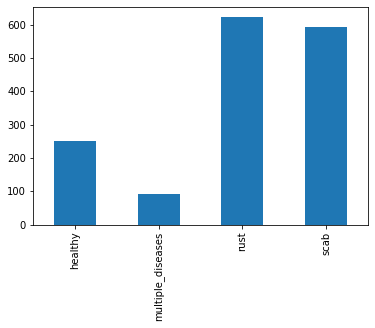

In [6]:
train_df[labels].sum().plot(kind='bar');

In [7]:
df = pd.DataFrame({
    'train': train_df['label'].value_counts()
})

df["train_pct"] = df["train"]/df["train"].sum(); df

,train,train_pct
rust,622,0.400000
scab,592,0.380707
healthy,250,0.160772
multiple_diseases,91,0.058521


In [8]:
# Save Data Df
train_df.to_csv('acus_pp_train_df_acus_layer2_c_resnet50_250s_s0.csv', index=False)

## Load Data into Fastai DataLoader

In [9]:
# Define Data Augmentation Functions
# taken from: https://isaac-flath.github.io/fastblog/computer%20vision/image%20classification/kaggle/2021/02/15/PlantPathologyKaggle.html

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order = None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']

        return PILImage.create(aug_img)
    
    
def get_train_aug(image_size): 
    return Compose([
        Resize(height=image_size[0], width=image_size[1]),
        OneOf([RandomBrightness(limit=0.1, p=1), RandomContrast(limit=0.1, p=1)]),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3)], p=0.5),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=20,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1,
        ),
    ])


def get_valid_aug(image_size): 
    return  Compose([
        Resize(height=image_size[0], width=image_size[1]),
    ])

In [10]:
# Load Data into Fastai DataLoader and Add Data Augmentation Functions
set_seed(seed, reproducible=True)

image_size = [224,244]
item_tfms  = [AlbumentationsTransform(get_train_aug(image_size), get_valid_aug(image_size))]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

db = DataBlock(
    blocks=(ImageBlock, CategoryBlock()), 
    getters=[ColReader('image_id', pref=img_dir, suff='.jpg'), ColReader('label')], 
    splitter=RandomSplitter(valid_pct=0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

dls = db.dataloaders(source=train_df, bs=25, seed=seed)

print('Classes: {}'.format(dls.vocab)); print()
print('Train Samples: {}'.format(len(dls.train_ds)))
print('Valid Samples: {}'.format(len(dls.valid_ds)))
print('Total Samples: {}'.format(len(dls.train_ds) + len(dls.valid_ds)))

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:2611: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "


Classes: ['healthy', 'multiple_diseases', 'rust', 'scab']

Train Samples: 1244
Valid Samples: 311
Total Samples: 1555


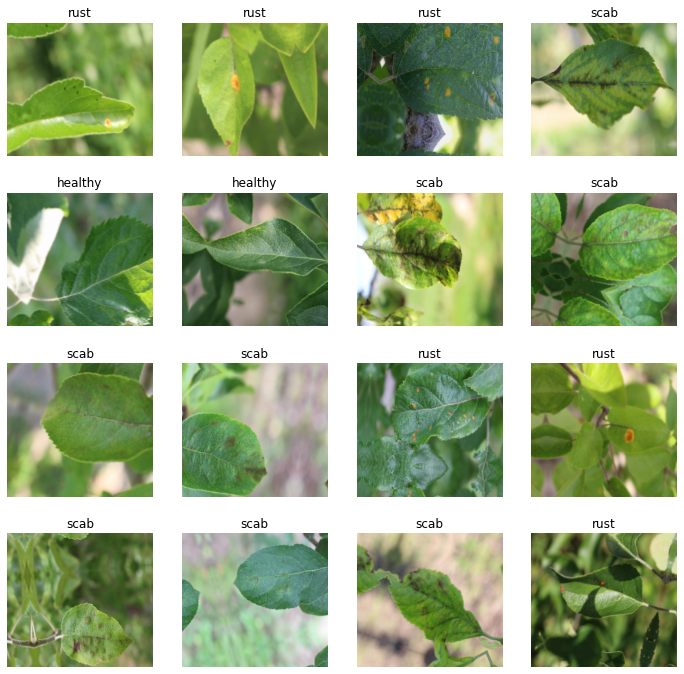

In [11]:
# Show a few Samples
dls.show_batch(max_n=16)

## Model Training

In [12]:
# Define Competition Metric
# see: https://www.kaggle.com/c/plant-pathology-2020-fgvc7/overview/evaluation

def comp_mean_roc_auc(preds, targs, labels=range(len(labels))):
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_mean_roc_auc(*args, labels=[3])

# Add Competition Matric and Some Other Metrics
metrics = [
    AccumMetric(comp_mean_roc_auc, flatten=False),
    AccumMetric(healthy_roc_auc, flatten=False),
    AccumMetric(multiple_diseases_roc_auc, flatten=False),
    AccumMetric(rust_roc_auc, flatten=False),
    AccumMetric(scab_roc_auc, flatten=False),
    accuracy,
]

In [13]:
# Create Learner
set_seed(seed, reproducible=True)

learn = cnn_learner(
    dls, resnet50, metrics = metrics
).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.001737800776027143)

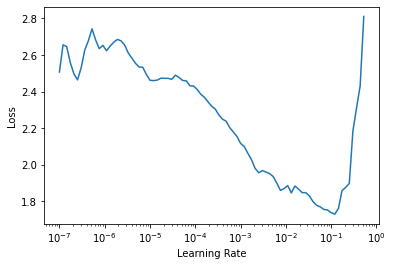

In [14]:
# Find Learning Rate
set_seed(seed, reproducible=True)

learn.lr_find()

In [15]:
# Model Training
set_seed(seed, reproducible=True)

learn.fine_tune(8, base_lr=1e-2, freeze_epochs=3)

epoch,train_loss,valid_loss,comp_mean_roc_auc,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,accuracy,time
0,1.181659,0.760113,0.883432,0.913602,0.698797,0.969652,0.951678,0.816720,00:59
1,0.976806,0.702904,0.875353,0.901149,0.695017,0.976808,0.928437,0.762058,00:59
2,0.740075,0.380590,0.908915,0.945441,0.718814,0.994378,0.977028,0.890675,00:58


epoch,train_loss,valid_loss,comp_mean_roc_auc,healthy_roc_auc,multiple_diseases_roc_auc,rust_roc_auc,scab_roc_auc,accuracy,time
0,0.571816,0.463256,0.930695,0.985517,0.756873,0.992504,0.987886,0.903537,01:17
1,0.508496,1.079836,0.839235,0.900230,0.517182,0.994804,0.944724,0.816720,01:16
2,0.478587,0.400736,0.930044,0.987126,0.751976,0.993526,0.987549,0.848875,01:17
3,0.405245,0.287560,0.930718,0.991418,0.745189,0.998850,0.987415,0.900322,01:15
4,0.331750,0.194056,0.974281,0.992720,0.915464,0.997870,0.991071,0.929260,01:16
5,0.246834,0.246913,0.971915,0.983525,0.913574,0.997381,0.993180,0.919614,01:16
6,0.205506,0.261514,0.964116,0.994789,0.871649,0.998552,0.991475,0.913183,01:15
7,0.164124,0.197247,0.966490,0.995556,0.879553,0.998680,0.992171,0.935691,01:16


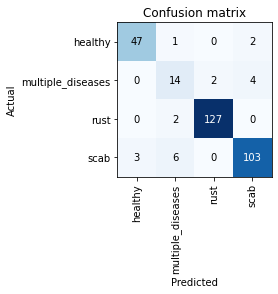

In [16]:
# Plot Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

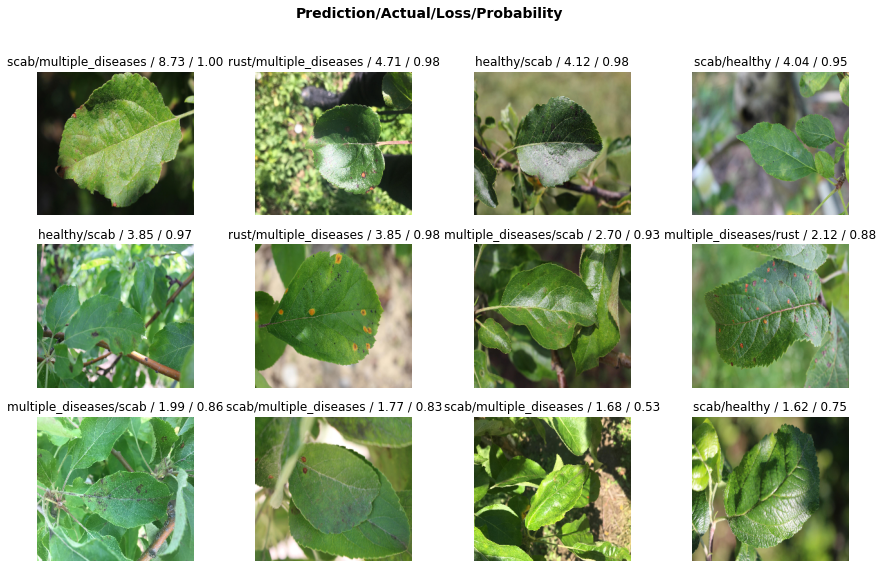

In [17]:
# Plot Top Losses
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

In [18]:
# Print Most Confused Classes
interp.most_confused()

[('scab', 'multiple_diseases', 6),
 ('multiple_diseases', 'scab', 4),
 ('scab', 'healthy', 3),
 ('healthy', 'scab', 2),
 ('multiple_diseases', 'rust', 2),
 ('rust', 'multiple_diseases', 2),
 ('healthy', 'multiple_diseases', 1)]

In [19]:
# Save Model
learn.save('acus_pp_train_df_acus_layer2_c_resnet50_250s_s0_fastai')
torch.save(learn.model, 'acus_pp_train_df_acus_layer2_c_resnet50_250s_s0.pth')

## Test Set Predictions

In [20]:
# Create Predictions of Testset
test_df = pd.read_csv(data_dir / 'test.csv')
test_dl = dls.test_dl(test_df)

test_preds, _ = learn.get_preds(dl=test_dl)

In [21]:
# Create Submission DataFrame
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=labels)], axis=1); sub_df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.002025,0.099901,0.897391,0.000682
1,Test_1,0.000614,0.050186,0.948786,0.000414
2,Test_2,0.000221,0.001233,0.000124,0.998423
3,Test_3,0.999709,0.000188,0.000031,0.000073
4,Test_4,0.000098,0.000969,0.998926,0.000008
...,...,...,...,...,...
1816,Test_1816,0.000089,0.003144,0.996759,0.000008
1817,Test_1817,0.144014,0.610481,0.009452,0.236052
1818,Test_1818,0.000531,0.000681,0.998761,0.000026
1819,Test_1819,0.991516,0.002686,0.004267,0.001531


In [22]:
# Save Submission DataFrame 
sub_df.to_csv('sub_acus_pp_train_df_acus_hclass_l2_c_resnet50_250s_s0.csv', index=False)